In [2]:
! pip install dm-sonnet tensorflow_probability

  Using cached https://files.pythonhosted.org/packages/4e/93/191e42ca27786d6875f74e7b756e34ef42f385f6d250bfc28aa48a1d1072/tensorflow_probability-0.6.0-py2.py3-none-any.whl


In [1]:
import os, glob
from tqdm import tqdm_notebook as tqdm

from imageio import imwrite

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import sonnet as snt

from clic.miracle_modules import ConvDS

tf.enable_eager_execution()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [4]:
def process_image(image, normalize=True):
    """
    normalize will adjust all pixels of the image to lie between 0 and 1
    for every colour dimension.
    """
    
    img_tensor = tf.image.decode_image(image)

    if normalize:
        img_tensor = tf.cast(img_tensor, tf.float32)
        img_tensor /= 255.
        
    return img_tensor


def load_and_process_image(image_path, normalize=True):
    
    img_raw = tf.read_file(image_path)
    return process_image(img_raw, normalize=normalize)

In [5]:
COMPRESSION_SUBDIR = 'datasets/miracle_image_compression'

TRAIN_DATASET_URL = 'https://data.vision.ee.ethz.ch/cvl/clic/professional_train.zip'
TRAIN_DATASET_ARCHIVE = 'train.zip'

VALIDATION_DATASET_URL = 'https://data.vision.ee.ethz.ch/cvl/clic/professional_valid.zip'
VALIDATION_DATASET_ARCHIVE = 'valid.zip'

valid_path = tf.keras.utils.get_file(fname=VALIDATION_DATASET_ARCHIVE, 
                                     origin=VALIDATION_DATASET_URL, 
                                     cache_subdir=COMPRESSION_SUBDIR,
                                     extract=True)

valid_path, _ = os.path.splitext(valid_path)

valid_path

'/Users/gergelyflamich/.keras/datasets/miracle_image_compression/valid'

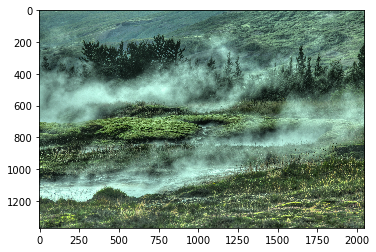

In [6]:
image_paths = glob.glob(valid_path + "/*.png")

test_img = load_and_process_image(image_paths[0], normalize=False)
plt.imshow(test_img)

In [ ]:
with tf.GradientTape() as tape:

    conv = snt.Conv2D(output_channels=10,
                      kernel_shape=(5, 5),
                      stride=2)

    print(test_img.shape.as_list())

    convolved = conv(test_img[tf.newaxis, ...])

    print(convolved.shape.as_list())

    conv_T = conv.transpose()

    deconvolved = conv_T(convolved)

    print(deconvolved.shape.as_list())
    
grads = tape.gradient(tf.reduce_sum(deconvolved), conv.get_all_variables())

plt.imshow(tf.nn.sigmoid(deconvolved[0, ...]))

In [ ]:
paths_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
image_dataset = paths_dataset.map(lambda im: load_and_process_image(im, normalize=False), 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
#image_dataset = image_dataset.shuffle(buffer_size=10)

dummy_dataset = image_dataset.take(4)

def create_random_crops(image, crop_coef=5, crop_size=256):
    
    w = image.shape[0]
    h = image.shape[1]
    
    num_crops = crop_coef * (w // crop_size) * (h // crop_size)
    
    crops = []
    
    for i in range(num_crops):
        crops.append(tf.image.random_crop(image, 
                                          size=(crop_size, crop_size, 3)))
        
    return crops

valid_processed_path = valid_path + "_processed/"

if not os.path.exists(valid_processed_path):
    os.mkdir(valid_processed_path)
    

    for idx, image in enumerate(dummy_dataset):

        print("Processing image {}".format(idx))
        
        crops = create_random_crops(image)

        for i, crop in tqdm(enumerate(crops), total=len(crops)):
            imwrite(valid_processed_path + "{}_{}.png".format(idx, i), crop)
            
        del crops
    
else:
    print("Data already processed!")

In [ ]:
xs, ys, chans = zip(*map(lambda x: x.as_list(), image_sizes))
print("X min: {}, X max: {}, Y min: {}, Y max: {}".format(min(xs), max(xs), min(ys), max(ys)))

In [7]:
tf.contrib.layers.gdn

<function tensorflow.contrib.layers.python.layers.layers.gdn(inputs, inverse=False, beta_min=1e-06, gamma_init=0.1, reparam_offset=3.814697265625e-06, data_format='channels_last', activity_regularizer=None, trainable=True, name=None, reuse=None)>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(0.82336134, shape=(), dtype=float32)


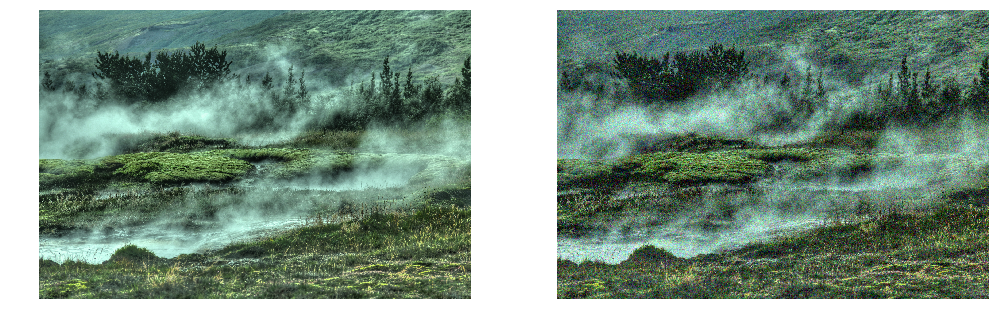

tf.Tensor(0.82336134, shape=(), dtype=float32)
tf.Tensor(-0.07383686, shape=(), dtype=float32)


In [31]:
image_dataset = paths_dataset.map(lambda im: load_and_process_image(im, normalize=True), 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

dummy_dataset = image_dataset.take(1)

for image in dummy_dataset:
    
    plt.figure(figsize=(17, 8))
    plt.subplot(121)
    plt.axis('off')
    plt.imshow(image)
    
    noise = tf.random.normal(image.shape, mean=0, stddev=0.1)
    
    with tf.GradientTape() as tape:
        c = tf.get_variable("const_test", initializer=tf.constant(0.9))

        noisy_image = image + noise
        #noisy_image = tf.clip_by_value(c * noisy_image, 0, 1)
        noisy_image = c * noisy_image
        
        msssim = tf.image.ssim_multiscale(noisy_image, image, 1.0)
        
        print(msssim)
        
        msssim = tf.reduce_sum(msssim)
    
    plt.subplot(122)
    plt.axis('off')
    plt.imshow(noisy_image)
    
    plt.show()

    print(msssim)
    
    print(tape.gradient(msssim, c))
    
#0.8245694

In [2]:
import numpy as np

conv_ds_test = ConvDS(output_channels=10,
                      num_convolutions=2,
                      kernel_shape=(3, 3))

conv_ds_tested = conv_ds_test(tf.convert_to_tensor(np.zeros((1, 20, 20, 3)), dtype=tf.float32))

deconv_us_test = conv_ds_test.transpose()

deconv_us_tested = deconv_us_test(conv_ds_tested)

final_conv = deconv_us_test.transpose()

final_conv_tested = final_conv(deconv_us_tested)

Instructions for updating:
Colocations handled automatically by placer.


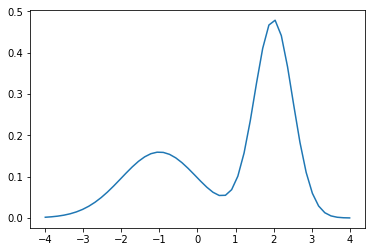

In [8]:
# MoG
mixture_coefs = [0.4, 0.6]

mog = tfd.Mixture(
    cat=tfd.Categorical(probs=mixture_coefs),
    components=[tfd.Normal(loc=-1., scale=1.),
                tfd.Normal(loc=2., scale=0.5)]
)

xs = np.linspace(-4, 4, 50)

density = mog.prob(xs)

plt.plot(xs, density)

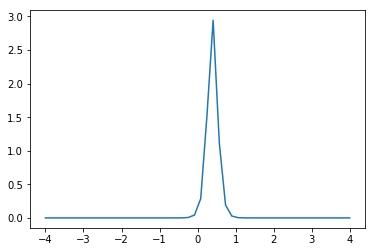

In [78]:
def non_parametric_prior(K=1, r=1):
    
    def g(x, k):
        
        a = tf.get_variable("a_{}".format(k), initializer=tf.constant(0., dtype=tf.float32), trainable=True)
        
        # Reparametrisation of a so that -1 <= a <= 1
        a = tf.tanh(a)
        
        return x + a * tf.tanh(x)
    
    
    def f(x, k, r_in, r_out):
        
        H = tf.get_variable("H_{}".format(k), shape=[r_out, r_in], trainable=True, )
        
        # Reparametrisation of H so that H >= 0
        H = tf.nn.softplus(H)
        
        b = tf.get_variable("b_{}".format(k), shape=[r_out, 1], trainable=True)
        
        return tf.matmul(H, x) + b
    
    
    def prior_cdf(x):
        
        input_shape = x.shape.as_list()[0]
        
        if K > 1:
            
            x = g(f(x, 0, input_shape, r), 0)

            for k in range(K - 1):

                x = g(f(x, k, r, r), k)

            x = tf.nn.sigmoid(f(x, K, r, 1))
            
        else:
            
            x = tf.nn.sigmoid(f(x, K, input_shape, 1))
        
        return x
    
    
    def prior_pdf(x):
        
        x_var = tf.get_variable("x_var", initializer=tf.constant(x, dtype=tf.float32))
        
        with tf.GradientTape() as tape: 
            c = prior_cdf(x_var)
            
        return tape.gradient(c, x_var)
    
    return prior_cdf, prior_pdf

c, p = non_parametric_prior(K = 4, r = 3)

c(tf.ones((2, 1)))
p(tf.ones((1, 2)))

npp_density = p(tf.convert_to_tensor(xs[None, ...], dtype=tf.float32))

plt.plot(xs, npp_density[0])